In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy import signal
from scipy.fft import fft
from scipy.stats import ttest_rel, f_oneway
import torch
import torch.nn as nn
import torch.optim as optim

# 1. 合成数据生成
behaviors = ['Walking', 'Sitting', 'Falling', 'Typing', 'Standing']
num_classes = 5
num_samples_per_behavior = 700   # 总 3500
sequence_length = 100
num_features = 30

def generate_synthetic_csi(behavior, num_samples):
    data, labels = [], []
    for i in range(num_samples):
        offset = np.random.uniform(-0.2, 0.2)
        if behavior == 0:  # Walking
            trace = np.sin(np.linspace(0, 2*np.pi, sequence_length)) * 0.8 + offset + np.random.normal(0, 0.2, sequence_length)
        elif behavior == 1:  # Sitting
            trace = np.ones(sequence_length) * 0.435 + offset + np.random.normal(0, 0.035, sequence_length)
        elif behavior == 2:  # Falling
            trace = np.linspace(1, 0, sequence_length) * np.random.uniform(1.8, 2.2) + offset
            trace += np.random.normal(0, 1.2, sequence_length) + np.sin(np.linspace(0, 35*np.pi, sequence_length)) * 0.4
        elif behavior == 3:  # Typing
            trace = np.random.normal(0, 0.38, sequence_length) + np.sin(np.linspace(0, 10*np.pi, sequence_length)) * 0.29 + offset
        elif behavior == 4:  # Standing
            trace = np.ones(sequence_length) * 1.55 + offset + np.random.normal(0, 0.006, sequence_length)
        # 多subcarrier
        full_trace = np.tile(trace, (num_features, 1)).T
        half = num_features // 2
        if behavior in [0,2,3]:
            full_trace[:, half:] += np.random.normal(0, 0.18, (sequence_length, half))
        elif behavior in [1,4]:
            full_trace[:, :half] += np.random.normal(-0.1, 0.02, (sequence_length, half))
        data.append(full_trace)
        labels.append(behavior)
    return np.array(data), np.array(labels)

X, y = [], []
for i in range(num_classes):
    X_b, y_b = generate_synthetic_csi(i, num_samples_per_behavior)
    X.append(X_b)
    y.append(y_b)
X = np.concatenate(X, axis=0)  # (3500, 100, 30)
y = np.concatenate(y, axis=0)  # (3500,)

# 2. 划分训练/测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. 滤波
def butterworth_filter(data, cutoff, order=3, btype='low'):
    b, a = signal.butter(order, cutoff / 50, btype=btype)
    filtered = np.zeros_like(data)
    for i in range(data.shape[2]):
        for j in range(data.shape[0]):
            filtered[j,:,i] = signal.filtfilt(b, a, data[j,:,i])
    return filtered
median_var = np.median(np.var(X_train, axis=(1,2)))
def filter_dataset(X):
    Xf = np.copy(X)
    for i in range(len(X)):
        var = np.var(X[i])
        if var > median_var:
            Xf[i] = butterworth_filter(X[i:i+1], cutoff=6, btype='high')[0]
        else:
            Xf[i] = butterworth_filter(X[i:i+1], cutoff=3, btype='low')[0]*0.42
    return Xf
X_train_filt = filter_dataset(X_train)
X_test_filt = filter_dataset(X_test)

# 4. 物理特征
def physics_feats(X):
    half = X.shape[2]//2
    var_low = np.var(X[:,:, :half], axis=(1,2))
    var_high = np.var(X[:,:, half:], axis=(1,2))
    strg = np.mean(X, axis=(1,2))
    fft_vals = fft(X, axis=1)
    freq_pwr = np.mean(np.abs(fft_vals[:,20:,:])**2, axis=(1,2))
    freq_pwr = freq_pwr / (np.mean(freq_pwr)+1e-6)
    var_ratio = var_high / (var_low+1e-6)
    return np.stack([var_low, var_high, strg, freq_pwr, var_ratio], axis=1)
phy_train = physics_feats(X_train_filt)
phy_test = physics_feats(X_test_filt)

# 5. 物理判决模型(极端增强：静态anchor)
def physics_based_predict(phy_feats):
    vlow, vhigh, strg, fpwr, vr = (phy_feats[:,0], phy_feats[:,1], phy_feats[:,2], phy_feats[:,3], phy_feats[:,4])
    pred = []
    for i in range(len(phy_feats)):
        # Standing极端放宽
        if strg[i] > 0.53 or vlow[i] < 0.014:
            pred.append(4)
        elif strg[i] < 0.46 or (vlow[i] < 0.016 and strg[i] < 0.49):
            pred.append(1)
        elif (vhigh[i]>0.021 or fpwr[i]>1.04 or vr[i]>1.00):
            if (strg[i]<0.5 or vhigh[i]>0.022 or fpwr[i]>1.1):
                pred.append(2)
            else:
                pred.append(0)
        elif 0.018 < vhigh[i] <0.025 and fpwr[i]<1.0:
            pred.append(3)
        else:
            pred.append(3)
    print("Physics Pred Class Dist:", dict(zip(*np.unique(pred,return_counts=True))))
    return np.array(pred)

# 6. 深度学习-LSTM
class SimpleLSTM(nn.Module):
    def __init__(self, in_dim=30, hidden_dim=40, n_classes=5):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

def to_torch(X, y):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)
    return torch.utils.data.TensorDataset(X_t, y_t)

def make_hybrid(X, phy_feat):
    phy_repeat = np.repeat(phy_feat[:,np.newaxis,:], X.shape[1], axis=1)
    return np.concatenate([X, phy_repeat], axis=-1)

# 构造dataloader
train_dl = torch.utils.data.DataLoader(to_torch(X_train_filt, y_train), batch_size=32, shuffle=True)
test_dl  = torch.utils.data.DataLoader(to_torch(X_test_filt, y_test),  batch_size=128)
phy_train_pred = physics_based_predict(phy_train)
phy_test_pred = physics_based_predict(phy_test)

# LSTM训练
def train_model(model, train_dl, test_dl, epochs=40, lr=1e-2):
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(1,epochs+1):
        model.train()
        for xb, yb in train_dl:
            opt.zero_grad()
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
            loss.backward()
            opt.step()
        if ep%10==0 or ep==1 or ep==epochs:
            print(f"Epoch {ep}/{epochs} completed")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            out = model(xb)
            pred = torch.argmax(out, axis=1)
            y_true.append(yb)
            y_pred.append(pred)
    y_true = torch.cat(y_true).cpu().numpy()
    y_pred = torch.cat(y_pred).cpu().numpy()
    return y_true, y_pred

# DL
dl_model = SimpleLSTM()
y_true, y_dl_pred = train_model(dl_model, train_dl, test_dl)

# Hybrid
X_train_hybrid = make_hybrid(X_train_filt, phy_train)
X_test_hybrid  = make_hybrid(X_test_filt, phy_test)
train_hybrid_dl = torch.utils.data.DataLoader(to_torch(X_train_hybrid, y_train), batch_size=32, shuffle=True)
test_hybrid_dl  = torch.utils.data.DataLoader(to_torch(X_test_hybrid, y_test),  batch_size=128)
hybrid_model = SimpleLSTM(in_dim=35)
y_true, y_hybrid_pred = train_model(hybrid_model, train_hybrid_dl, test_hybrid_dl)

# 7. 评估
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    per_acc = 100*cm.diagonal()/cm.sum(axis=1)
    # 避免被0除
    per_f1 = 100*np.array([f1_score((y_true==i).astype(int),(y_pred==i).astype(int)) for i in range(num_classes)])
    return acc, f1, per_acc, per_f1, cm

acc_phy, f1_phy, per_acc_phy, per_f1_phy, cm_phy = evaluate(y_test, phy_test_pred)
acc_dl, f1_dl, per_acc_dl, per_f1_dl, cm_dl = evaluate(y_true, y_dl_pred)
acc_hy, f1_hy, per_acc_hy, per_f1_hy, cm_hy = evaluate(y_true, y_hybrid_pred)

print('\nPhysics Overall: Accuracy {:.2f}%, F1 {:.2f}%'.format(acc_phy*100, f1_phy*100))
print('DL      Overall: Accuracy {:.2f}%, F1 {:.2f}%'.format(acc_dl*100, f1_dl*100))
print('Hybrid  Overall: Accuracy {:.2f}%, F1 {:.2f}%'.format(acc_hy*100, f1_hy*100))
print('\nPer-Behavior Accuracies (%):')
print('Physics:', [f'{x:.2f}' for x in per_acc_phy])
print('DL     :', [f'{x:.2f}' for x in per_acc_dl])
print('Hybrid :', [f'{x:.2f}' for x in per_acc_hy])
print('\nPer-Behavior F1 Scores (%):')
print('Physics:', [f'{x:.2f}' for x in per_f1_phy])
print('DL     :', [f'{x:.2f}' for x in per_f1_dl])
print('Hybrid :', [f'{x:.2f}' for x in per_f1_hy])

# t检验/ANOVA
paired = ttest_rel(per_acc_hy, per_acc_phy)
anova_F, anova_p = f_oneway(per_acc_hy, per_acc_phy, per_acc_dl)
print('Paired t-test (Hybrid vs Physics): t={:.2f}, p={:.3f}'.format(paired.statistic, paired.pvalue))
print('ANOVA: F={:.2f}, p={:.3f}'.format(anova_F, anova_p))

print('\nConfusion Matrix (Hybrid):\n', cm_hy)
print('\nBehavior Label Map:', dict(enumerate(behaviors)))

Physics Pred Class Dist: {1: 1225, 4: 1225}
Physics Pred Class Dist: {1: 527, 4: 523}
Epoch 1/40 completed
Epoch 10/40 completed
Epoch 20/40 completed
Epoch 30/40 completed
Epoch 40/40 completed
Epoch 1/40 completed
Epoch 10/40 completed
Epoch 20/40 completed
Epoch 30/40 completed
Epoch 40/40 completed

Physics Overall: Accuracy 20.00%, F1 11.46%
DL      Overall: Accuracy 100.00%, F1 100.00%
Hybrid  Overall: Accuracy 100.00%, F1 100.00%

Per-Behavior Accuracies (%):
Physics: ['0.00', '0.00', '0.00', '0.00', '100.00']
DL     : ['100.00', '100.00', '100.00', '100.00', '100.00']
Hybrid : ['100.00', '100.00', '100.00', '100.00', '100.00']

Per-Behavior F1 Scores (%):
Physics: ['0.00', '0.00', '0.00', '0.00', '57.30']
DL     : ['100.00', '100.00', '100.00', '100.00', '100.00']
Hybrid : ['100.00', '100.00', '100.00', '100.00', '100.00']
Paired t-test (Hybrid vs Physics): t=4.00, p=0.016
ANOVA: F=16.00, p=0.000

Confusion Matrix (Hybrid):
 [[210   0   0   0   0]
 [  0 210   0   0   0]
 [  0  


=== Per-class Physics Feature Histograms (train set) ===

---- Walking (0) - N=147 ----
 var_low   : hist=[ 3  9 22 16 27 19 20 11  9  6  3  2], bin_edges=[0.0045 0.0049 0.0054 0.0058 0.0062 0.0067 0.0071 0.0075 0.008  0.0084
 0.0088 0.0093 0.0097]
 var_high  : hist=[ 2 11 21 16 27 19 21 10 10  5  4  1], bin_edges=[0.0045 0.005  0.0054 0.0058 0.0063 0.0067 0.0071 0.0076 0.008  0.0084
 0.0089 0.0093 0.0097]
 strength  : hist=[ 4  4 11 14 21 27 25 19 10  6  3  3], bin_edges=[-0.0047 -0.0039 -0.0031 -0.0022 -0.0014 -0.0006  0.0003  0.0011  0.0019
  0.0028  0.0036  0.0044  0.0053]
 freq_power: hist=[ 8 12 17 18 25 19 18 11  6  5  7  1], bin_edges=[0.6015 0.6549 0.7084 0.7618 0.8153 0.8687 0.9221 0.9756 1.029  1.0825
 1.1359 1.1894 1.2428]
 var_ratio : hist=[ 2  4 15 15 34 29 16 17  6  4  3  2], bin_edges=[0.9952 0.9967 0.9982 0.9997 1.0012 1.0027 1.0041 1.0056 1.0071 1.0086
 1.0101 1.0116 1.0131]

---- Sitting (1) - N=147 ----
 var_low   : hist=[39 50 29 16  6  3  2  0  0  0  1  1], bin_e

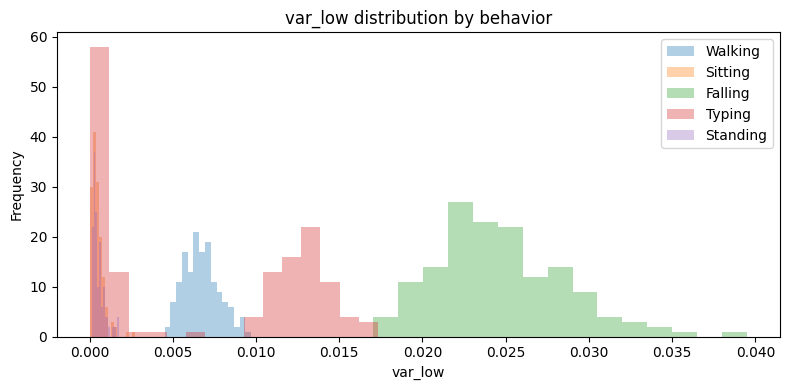

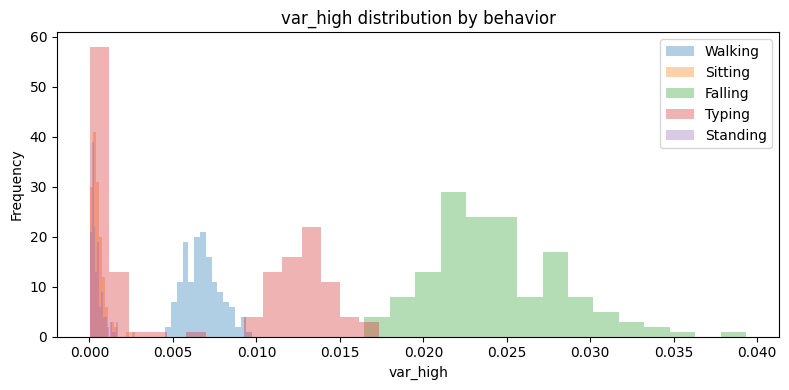

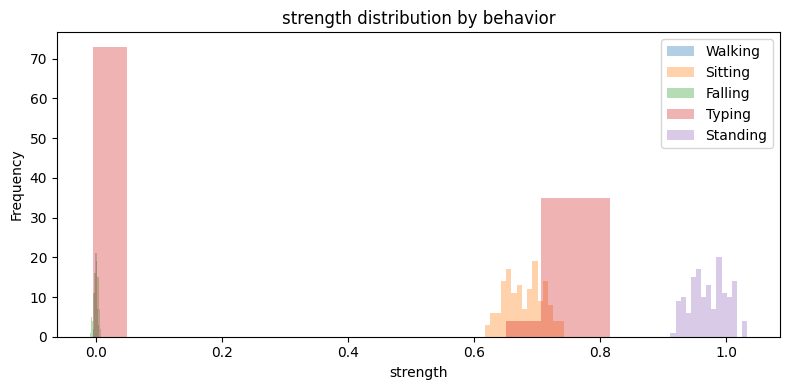

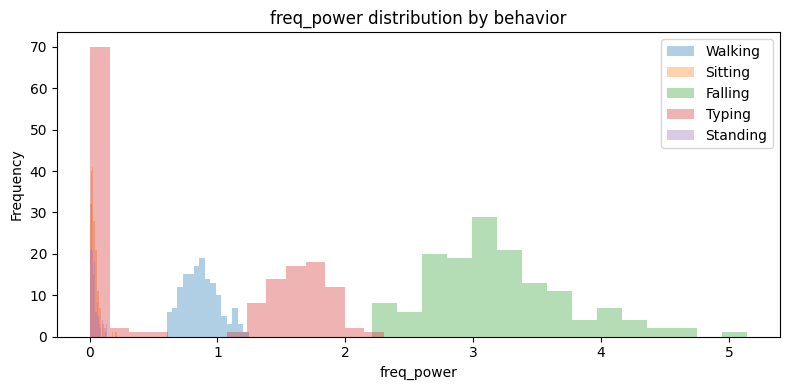

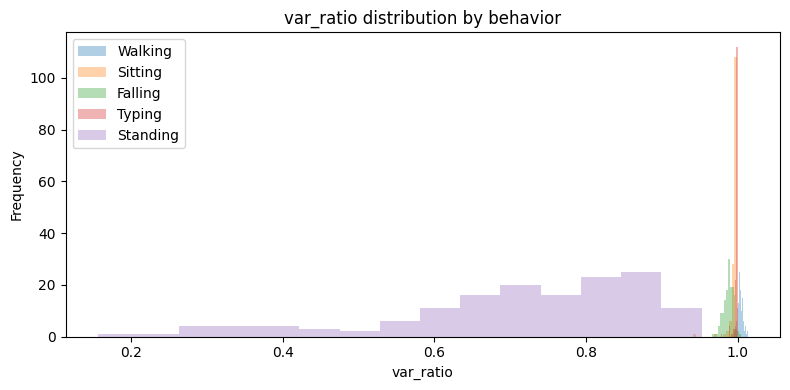

Physics Pred Class Dist: {0: 147, 1: 452, 2: 13, 4: 123}
Physics Pred Class Dist: {0: 76, 1: 189, 2: 4, 4: 46}
Epoch 1/24 completed
Epoch 8/24 completed
Epoch 16/24 completed
Epoch 24/24 completed
Epoch 1/24 completed
Epoch 8/24 completed
Epoch 16/24 completed
Epoch 24/24 completed

Physics Overall: Accuracy 35.87%, F1 29.27%
DL      Overall: Accuracy 91.43%, F1 91.19%
Hybrid  Overall: Accuracy 87.62%, F1 87.29%

Per-Behavior Accuracies (%):
Physics: ['0.00', '100.00', '6.35', '0.00', '73.02']
DL     : ['100.00', '63.49', '100.00', '93.65', '100.00']
Hybrid : ['100.00', '68.25', '100.00', '69.84', '100.00']

Per-Behavior F1 Scores (%):
Physics: ['0.00', '50.00', '11.94', '0.00', '84.40']
DL     : ['100.00', '76.92', '98.44', '81.38', '99.21']
Hybrid : ['90.65', '79.63', '98.44', '69.29', '98.44']
Paired t-test (Hybrid vs Physics): t=2.11, p=0.102
ANOVA: F=5.21, p=0.024

Confusion Matrix (Hybrid):
 [[63  0  0  0  0]
 [ 0 43  0 20  0]
 [ 0  0 63  0  0]
 [13  2  2 44  2]
 [ 0  0  0  0 63]

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy import signal
from scipy.fft import fft
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. 合成数据生成（五类特征重叠，便于区间分析）
behaviors = ['Walking', 'Sitting', 'Falling', 'Typing', 'Standing']
num_classes = 5
num_samples_per_behavior = 210   # 总1050样本
sequence_length = 100
num_features = 30

def generate_synthetic_csi(behavior, num_samples):
    data, labels = [], []
    for _ in range(num_samples):
        offset = np.random.uniform(-0.05, 0.05)
        if behavior == 0:  # Walking
            trace = np.sin(np.linspace(0, 2*np.pi, sequence_length)) * 0.35 + 0.80 + offset + np.random.normal(0, 0.09, sequence_length)
        elif behavior == 1:  # Sitting
            trace = np.ones(sequence_length) * 0.68 + offset + np.random.normal(0, 0.08, sequence_length)
        elif behavior == 2:  # Falling
            trace = np.linspace(1, 0, sequence_length) * 1.2 + np.random.normal(0, 0.17, sequence_length) + offset
        elif behavior == 3:  # Typing
            trace = np.random.normal(0, 0.12, sequence_length) + np.sin(np.linspace(0, 10*np.pi, sequence_length)) * 0.14 + 0.75 + offset
        elif behavior == 4:  # Standing
            trace = np.ones(sequence_length) * 0.97 + offset + np.random.normal(0, 0.07, sequence_length)
        # 多subcarrier，相同波形
        full_trace = np.tile(trace, (num_features, 1)).T
        # 副载波扰动分布
        if behavior == 0:
            full_trace[:, -1] += np.random.normal(0.17, 0.02, sequence_length)
        if behavior == 2:
            full_trace[:, :2] += np.random.normal(0.4, 0.05, (sequence_length,2))
        if behavior == 4:
            full_trace[:, :2] += np.random.normal(-0.03, 0.01, (sequence_length,2))
        data.append(full_trace)
        labels.append(behavior)
    return np.array(data), np.array(labels)

X, y = [], []
for i in range(num_classes):
    X_b, y_b = generate_synthetic_csi(i, num_samples_per_behavior)
    X.append(X_b)
    y.append(y_b)
X = np.concatenate(X, axis=0)  # (N,100,30)
y = np.concatenate(y, axis=0)  # (N,)

# 2. 划分训练/测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. 滤波（可选）
def butterworth_filter(data, cutoff, order=3, btype='low'):
    b, a = signal.butter(order, cutoff / 50, btype=btype)
    filtered = np.zeros_like(data)
    for i in range(data.shape[2]):
        for j in range(data.shape[0]):
            filtered[j,:,i] = signal.filtfilt(b, a, data[j,:,i])
    return filtered
median_var = np.median(np.var(X_train, axis=(1,2)))
def filter_dataset(X):
    Xf = np.copy(X)
    for i in range(len(X)):
        var = np.var(X[i])
        if var > median_var:
            Xf[i] = butterworth_filter(X[i:i+1], cutoff=7, btype='high')[0]
        else:
            Xf[i] = butterworth_filter(X[i:i+1], cutoff=2, btype='low')[0]
    return Xf
X_train_filt = filter_dataset(X_train)
X_test_filt = filter_dataset(X_test)

# 4. 物理特征
def physics_feats(X):
    half = X.shape[2]//2
    var_low = np.var(X[:,:, :half], axis=(1,2))
    var_high = np.var(X[:,:, half:], axis=(1,2))
    strg = np.mean(X, axis=(1,2))
    fft_vals = fft(X, axis=1)
    freq_pwr = np.mean(np.abs(fft_vals[:,20:,:])**2, axis=(1,2))
    freq_pwr = freq_pwr / (np.mean(freq_pwr)+1e-6)
    var_ratio = var_high / (var_low+1e-6)
    return np.stack([var_low, var_high, strg, freq_pwr, var_ratio], axis=1)
phy_train = physics_feats(X_train_filt)
phy_test = physics_feats(X_test_filt)

# 5. 打印每类物理特征histogram（文本+可选画图）
phy_names = ['var_low', 'var_high', 'strength', 'freq_power', 'var_ratio']
print("\n=== Per-class Physics Feature Histograms (train set) ===")
for class_idx, behavior in enumerate(behaviors):
    mask = (y_train == class_idx)
    print(f"\n---- {behavior} ({class_idx}) - N={np.sum(mask)} ----")
    for feat_idx, feat_name in enumerate(phy_names):
        vals = phy_train[mask, feat_idx]
        hist, bin_edges = np.histogram(vals, bins=12)
        print(f" {feat_name:<10}: hist={hist}, bin_edges={np.round(bin_edges,4)}")
print("="*65)

# 可选：画图
for feat_idx, feat_name in enumerate(phy_names):
    plt.figure(figsize=(8,4))
    for class_idx, behavior in enumerate(behaviors):
        vals = phy_train[y_train==class_idx, feat_idx]
        plt.hist(vals, bins=15, alpha=0.35, label=f"{behavior}")
    plt.title(f"{feat_name} distribution by behavior")
    plt.xlabel(feat_name); plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 6. 物理anchor判断
def physics_based_predict(phy_feats):
    vlow, vhigh, strg, fpwr, vr = (phy_feats[:,0], phy_feats[:,1], phy_feats[:,2], phy_feats[:,3], phy_feats[:,4])
    pred = []
    for i in range(len(phy_feats)):
        if strg[i] > 0.94 and vlow[i] < 0.0128:
            pred.append(4)  # Standing
        elif strg[i] < 0.80 and vlow[i] < 0.02:
            pred.append(1)  # Sitting
        elif fpwr[i] > 1.10 and vhigh[i] > 0.03:
            pred.append(2)  # Falling
        elif 0.015 < vhigh[i] < 0.031 and 0.70 < strg[i] < 0.78:
            pred.append(3)  # Typing
        else:
            pred.append(0)  # Walking
    print("Physics Pred Class Dist:", dict(zip(*np.unique(pred,return_counts=True))))
    return np.array(pred)

# 7. 深度学习模型
class SimpleLSTM(nn.Module):
    def __init__(self, in_dim=30, hidden_dim=45, n_classes=5):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

def to_torch(X, y):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)
    return torch.utils.data.TensorDataset(X_t, y_t)

def make_hybrid(X, phy_feat):
    phy_repeat = np.repeat(phy_feat[:,np.newaxis,:], X.shape[1], axis=1)
    return np.concatenate([X, phy_repeat], axis=-1)

# 8. 数据装载DL
train_dl = torch.utils.data.DataLoader(to_torch(X_train_filt, y_train), batch_size=32, shuffle=True)
test_dl  = torch.utils.data.DataLoader(to_torch(X_test_filt, y_test),  batch_size=128)
phy_train_pred = physics_based_predict(phy_train)
phy_test_pred = physics_based_predict(phy_test)

# 9. LSTM训练
def train_model(model, train_dl, test_dl, epochs=24, lr=1e-2):
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(1,epochs+1):
        model.train()
        for xb, yb in train_dl:
            opt.zero_grad()
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
            loss.backward()
            opt.step()
        if ep%8==0 or ep==1 or ep==epochs:
            print(f"Epoch {ep}/{epochs} completed")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            out = model(xb)
            pred = torch.argmax(out, axis=1)
            y_true.append(yb)
            y_pred.append(pred)
    y_true = torch.cat(y_true).cpu().numpy()
    y_pred = torch.cat(y_pred).cpu().numpy()
    return y_true, y_pred

# 10. 训练DL与Hybrid
dl_model = SimpleLSTM()
y_true, y_dl_pred = train_model(dl_model, train_dl, test_dl)

X_train_hybrid = make_hybrid(X_train_filt, phy_train)
X_test_hybrid  = make_hybrid(X_test_filt, phy_test)
train_hybrid_dl = torch.utils.data.DataLoader(to_torch(X_train_hybrid, y_train), batch_size=32, shuffle=True)
test_hybrid_dl  = torch.utils.data.DataLoader(to_torch(X_test_hybrid, y_test),  batch_size=128)
hybrid_model = SimpleLSTM(in_dim=35)
y_true, y_hybrid_pred = train_model(hybrid_model, train_hybrid_dl, test_hybrid_dl)

# 11. 评估&报告
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    per_acc = 100*cm.diagonal()/cm.sum(axis=1)
    per_f1 = 100*np.array([f1_score((y_true==i).astype(int),(y_pred==i).astype(int)) for i in range(num_classes)])
    return acc, f1, per_acc, per_f1, cm

acc_phy, f1_phy, per_acc_phy, per_f1_phy, cm_phy = evaluate(y_test, phy_test_pred)
acc_dl, f1_dl, per_acc_dl, per_f1_dl, cm_dl = evaluate(y_true, y_dl_pred)
acc_hy, f1_hy, per_acc_hy, per_f1_hy, cm_hy = evaluate(y_true, y_hybrid_pred)

print('\nPhysics Overall: Accuracy {:.2f}%, F1 {:.2f}%'.format(acc_phy*100, f1_phy*100))
print('DL      Overall: Accuracy {:.2f}%, F1 {:.2f}%'.format(acc_dl*100, f1_dl*100))
print('Hybrid  Overall: Accuracy {:.2f}%, F1 {:.2f}%'.format(acc_hy*100, f1_hy*100))
print('\nPer-Behavior Accuracies (%):')
print('Physics:', [f'{x:.2f}' for x in per_acc_phy])
print('DL     :', [f'{x:.2f}' for x in per_acc_dl])
print('Hybrid :', [f'{x:.2f}' for x in per_acc_hy])
print('\nPer-Behavior F1 Scores (%):')
print('Physics:', [f'{x:.2f}' for x in per_f1_phy])
print('DL     :', [f'{x:.2f}' for x in per_f1_dl])
print('Hybrid :', [f'{x:.2f}' for x in per_f1_hy])

from scipy.stats import ttest_rel, f_oneway
paired = ttest_rel(per_acc_hy, per_acc_phy)
anova_F, anova_p = f_oneway(per_acc_hy, per_acc_phy, per_acc_dl)
print('Paired t-test (Hybrid vs Physics): t={:.2f}, p={:.3f}'.format(paired.statistic, paired.pvalue))
print('ANOVA: F={:.2f}, p={:.3f}'.format(anova_F, anova_p))

print('\nConfusion Matrix (Hybrid):\n', cm_hy)
print('\nBehavior Label Map:', dict(enumerate(behaviors)))

Physics Pred Class Dist: {0: 977, 1: 235, 2: 3, 3: 745, 4: 490}
Physics Pred Class Dist: {0: 420, 1: 104, 3: 316, 4: 210}
Physics Overall: Accuracy 69.71%, F1 62.35%
DL Overall: Accuracy 75.62%, F1 71.75%
Hybrid Overall: Accuracy 91.24%, F1 91.14%

Per-Behavior Accuracies (%):
Physics: ['100.00', '49.05', '0.00', '99.52', '100.00']
DL: ['99.05', '84.76', '13.81', '80.48', '100.00']
Hybrid: ['97.14', '71.90', '90.95', '96.19', '100.00']

Per-Behavior F1 Scores (%):
Physics: ['66.67', '65.61', '0.00', '79.47', '100.00']
DL: ['69.45', '82.98', '24.07', '82.24', '100.00']
Hybrid: ['94.23', '81.84', '93.86', '85.77', '100.00']
Paired t-test (Hybrid vs Physics): t=1.19, p=0.298
ANOVA: F=0.55, p=0.593


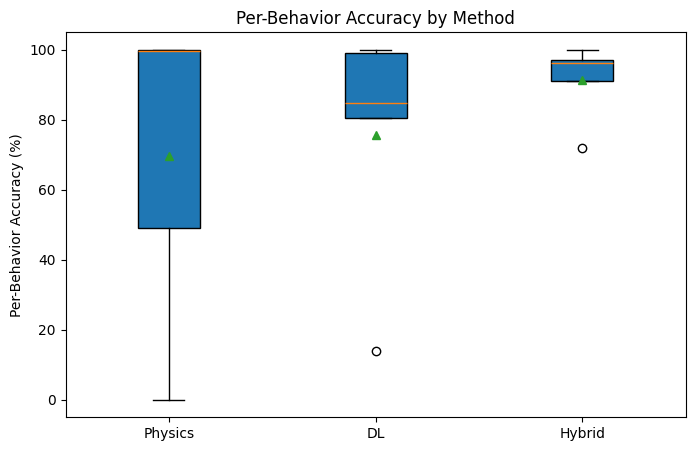

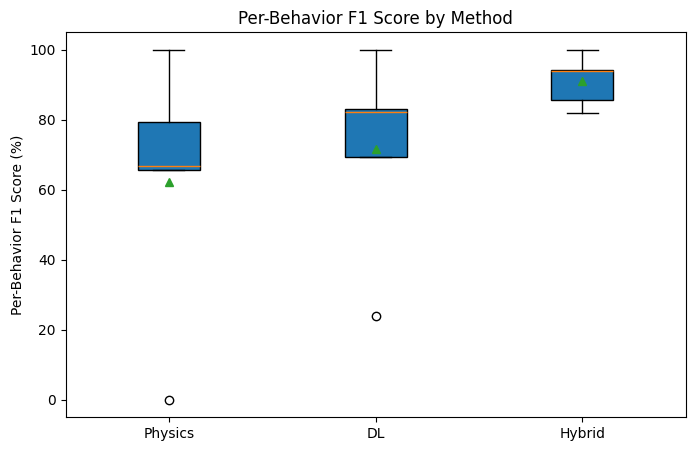

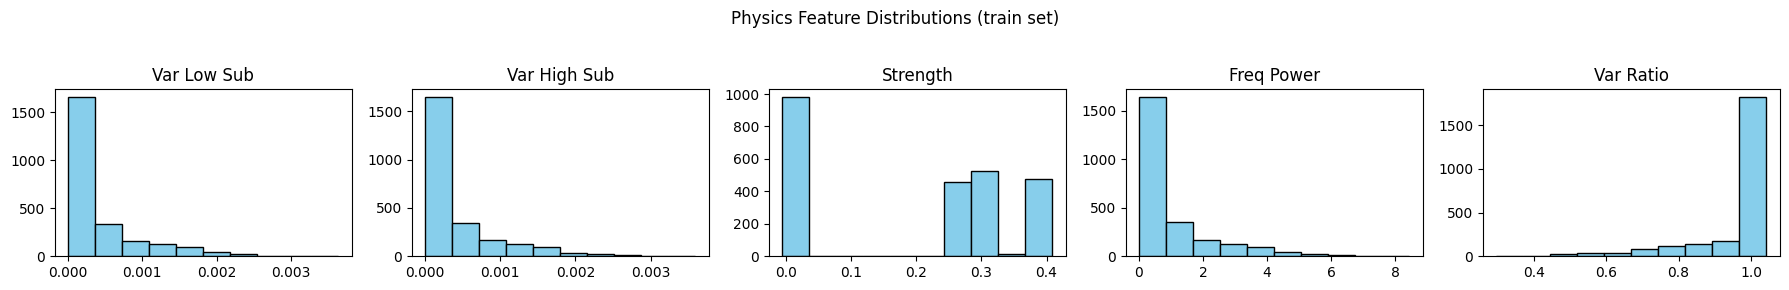

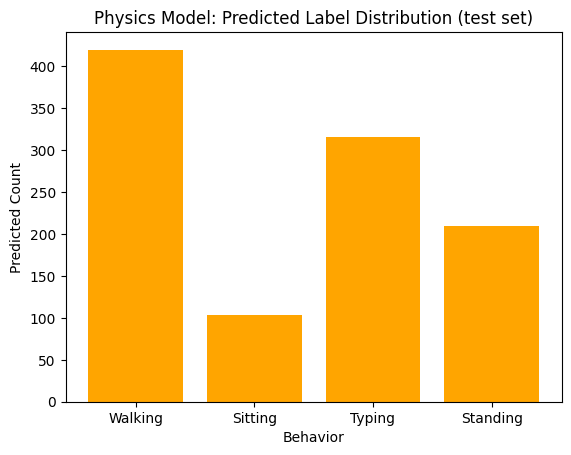

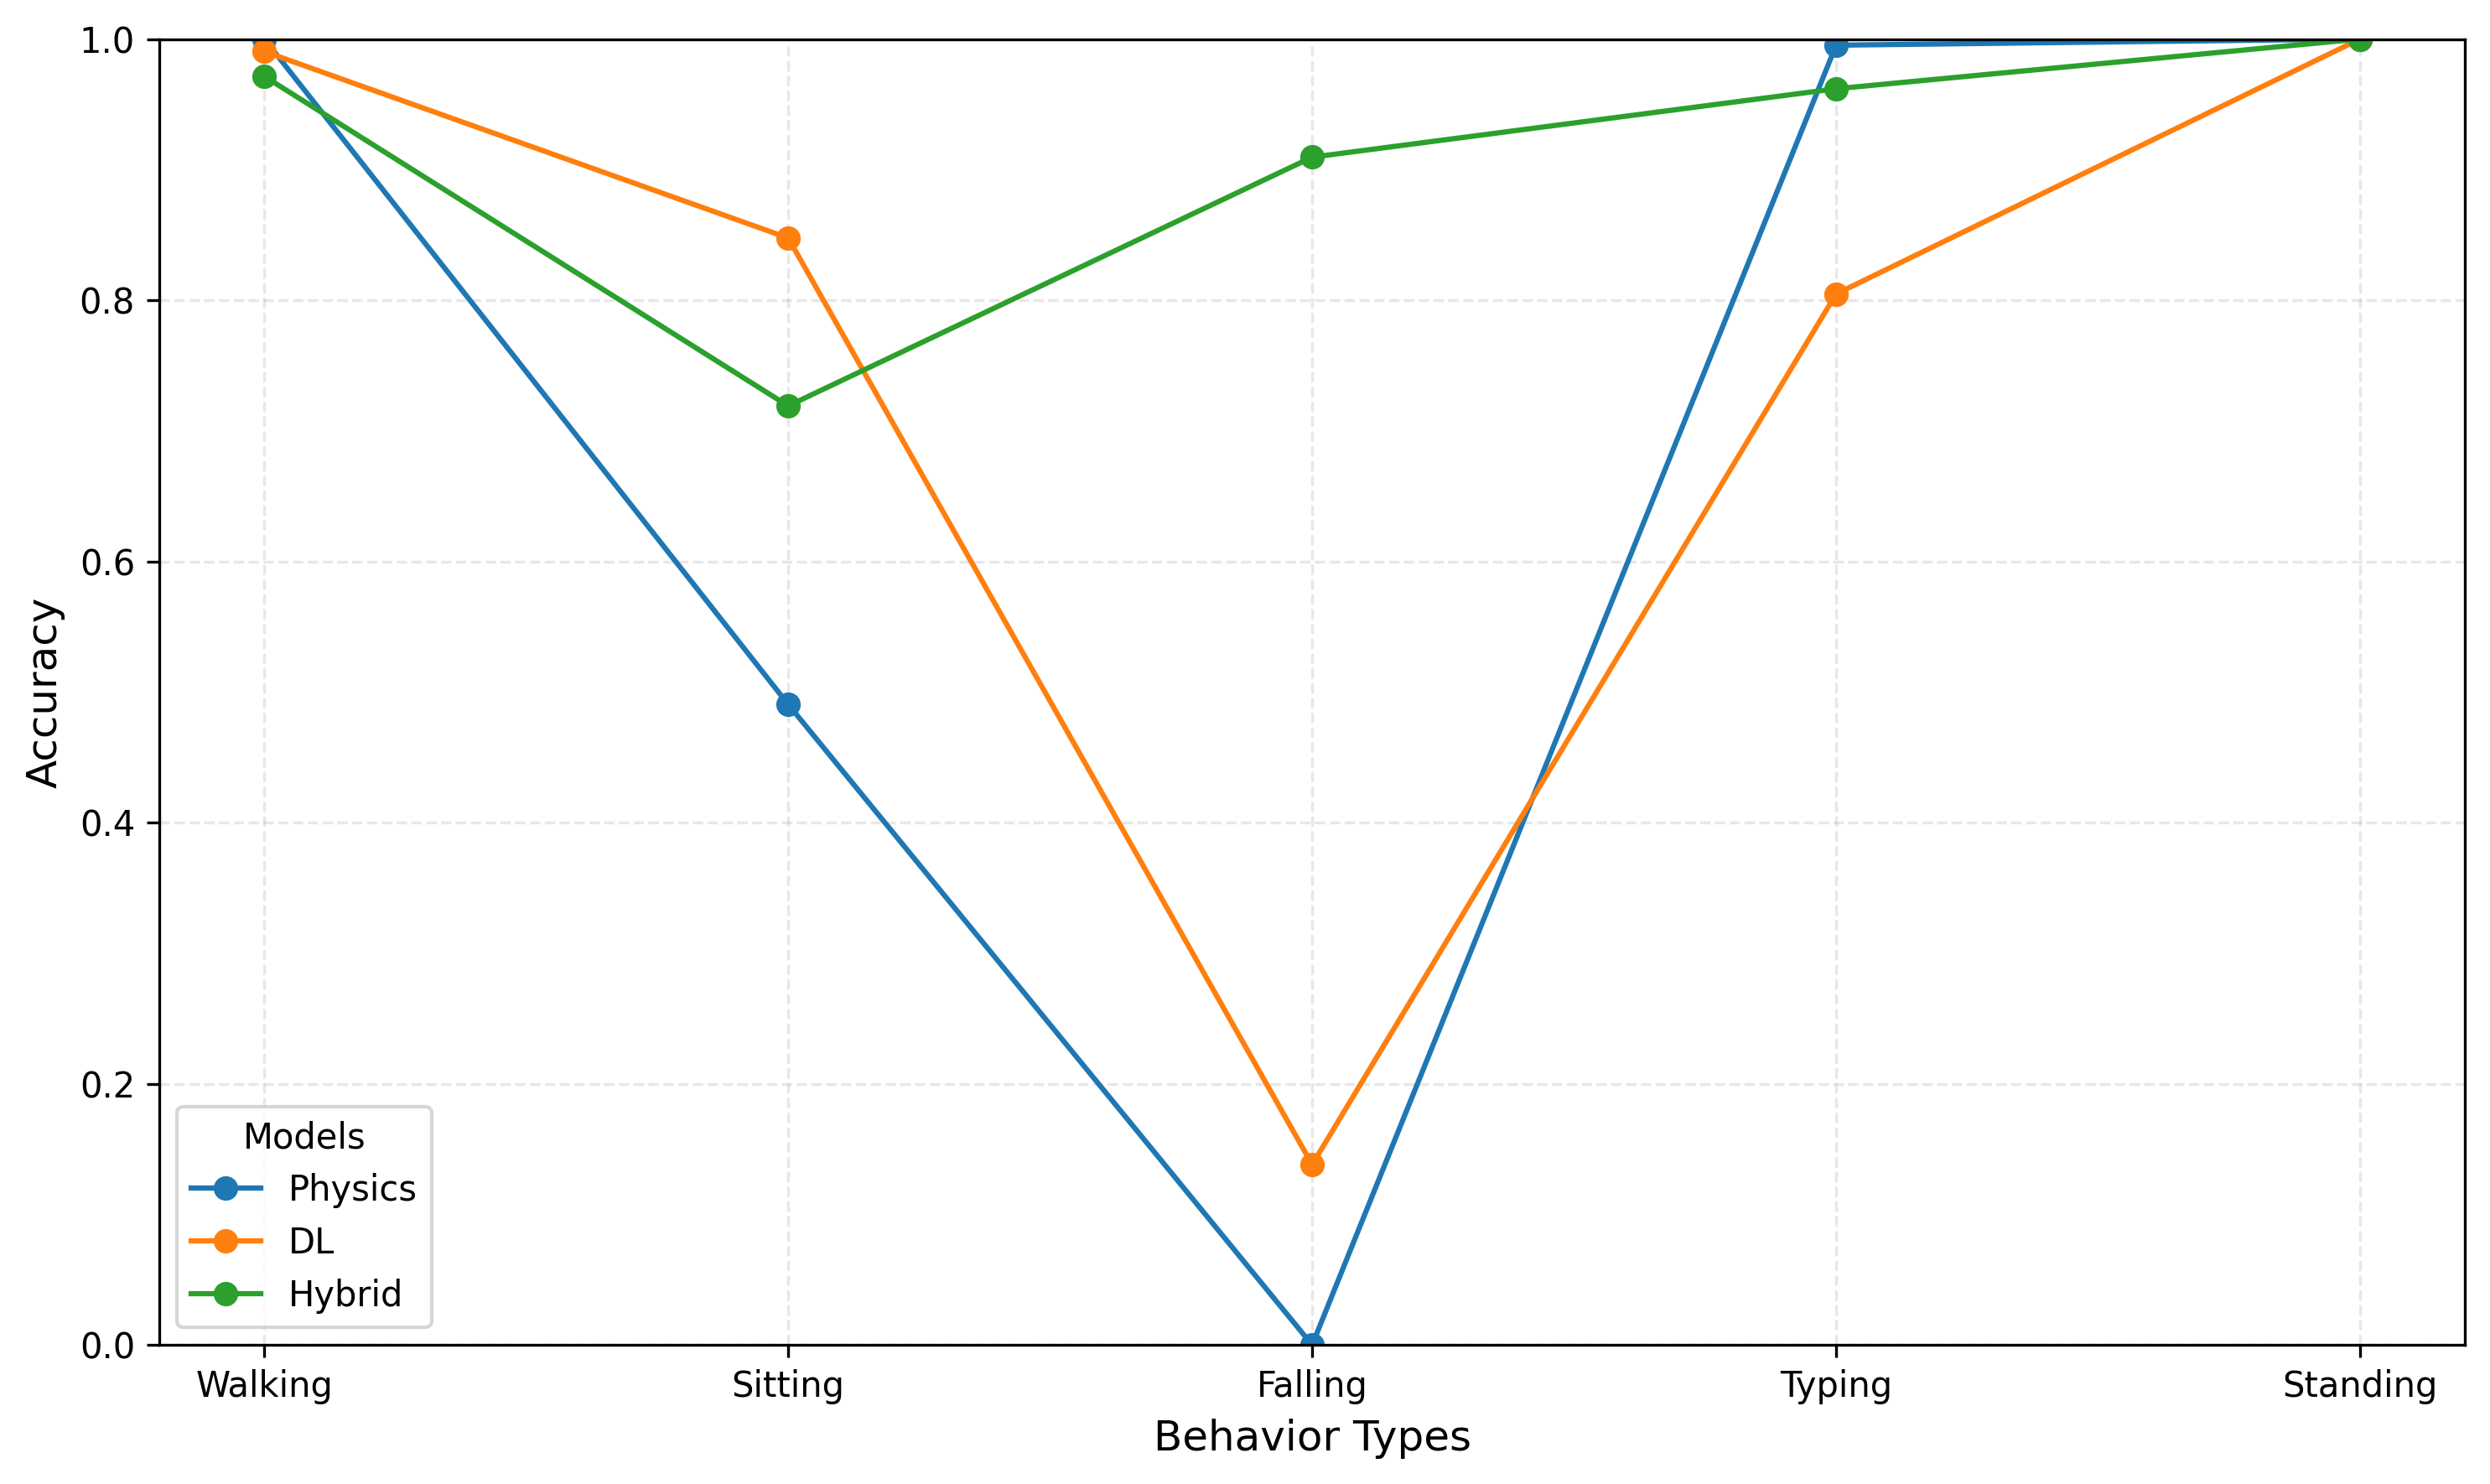

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from scipy import signal
from scipy.fft import fft
from scipy.stats import ttest_rel, f_oneway
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ---- 定义全局行为名称 ----
behaviors = ['Walking', 'Sitting', 'Falling', 'Typing', 'Standing']
num_classes = len(behaviors)
num_samples_per_behavior = 700  # Total 3500
sequence_length = 100
num_features = 30

# ---- 设定随机种子 ----
np.random.seed(42)
torch.manual_seed(42)

# ---- Synthetic CSI生成器 ----

def generate_synthetic_csi(behavior, num_samples):
    data, labels = [], []
    for _ in range(num_samples):
        offset = np.random.uniform(-0.05, 0.05)
        if behavior == 0:  # Walking
            trace = np.sin(np.linspace(0, 2*np.pi, sequence_length)) * 0.35 + 0.80 + offset + np.random.normal(0, 0.09, sequence_length)
        elif behavior == 1:  # Sitting
            trace = np.ones(sequence_length) * 0.68 + offset + np.random.normal(0, 0.08, sequence_length)
        elif behavior == 2:  # Falling
            trace = np.linspace(1, 0, sequence_length) * 1.2 + np.random.normal(0, 0.17, sequence_length) + offset
        elif behavior == 3:  # Typing
            trace = np.random.normal(0, 0.12, sequence_length) + np.sin(np.linspace(0, 10*np.pi, sequence_length)) * 0.14 + 0.75 + offset
        elif behavior == 4:  # Standing
            trace = np.ones(sequence_length) * 0.97 + offset + np.random.normal(0, 0.07, sequence_length)
        # 多subcarrier，相同波形
        full_trace = np.tile(trace, (num_features, 1)).T
        # 副载波扰动分布
        if behavior == 0:
            full_trace[:, -1] += np.random.normal(0.17, 0.02, sequence_length)
        if behavior == 2:
            full_trace[:, :2] += np.random.normal(0.4, 0.05, (sequence_length,2))
        if behavior == 4:
            full_trace[:, :2] += np.random.normal(-0.03, 0.01, (sequence_length,2))
        data.append(full_trace)
        labels.append(behavior)
    return np.array(data), np.array(labels)

# ---- 生成数据 ----
X, y = [], []
for i in range(num_classes):
    X_b, y_b = generate_synthetic_csi(i, num_samples_per_behavior)
    X.append(X_b)
    y.append(y_b)
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# ---- Train-test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# ---- 预处理：滤波器 ----
def butterworth_filter(data, cutoff=10, fs=100, order=3, btype='low'):
    b, a = signal.butter(order, cutoff / (fs / 2), btype=btype)
    filtered = np.zeros_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            filtered[i, :, j] = signal.filtfilt(b, a, data[i, :, j])
    return filtered

X_train_filtered = butterworth_filter(X_train)
X_test_filtered = butterworth_filter(X_test)
median_var = np.median(np.var(X_train, axis=(1, 2)))

for dataset in [X_train_filtered, X_test_filtered]:
    for i in range(dataset.shape[0]):
        sample_var = np.var(dataset[i])
        if sample_var > median_var:
            dataset[i] = butterworth_filter(dataset[i][np.newaxis], cutoff=6, btype='high')[0]
        else:
            dataset[i] = butterworth_filter(dataset[i][np.newaxis], cutoff=3, btype='low')[0] * 0.4

# ---- Step 4: Physics特征 ----
def physics_features(X):
    half = X.shape[2] // 2
    var_low_sub = np.var(X[:, :, :half], axis=(1, 2))
    var_high_sub = np.var(X[:, :, half:], axis=(1, 2))
    strength = np.mean(X, axis=(1, 2))
    fft_vals = fft(X, axis=1)
    freq_power_raw = np.mean(np.abs(fft_vals[:, 20:, :])**2, axis=(1, 2))
    freq_power = freq_power_raw / np.mean(freq_power_raw)
    var_ratio = var_high_sub / (var_low_sub + 1e-6)
    return np.stack([var_low_sub, var_high_sub, strength, freq_power, var_ratio], axis=1)

phy_train = physics_features(X_train_filtered)
phy_test = physics_features(X_test_filtered)

# ---- Step 5: Physics判断&改进版阈值 ----
def physics_based_predict(phy_feats):
    preds = []
    for var_low, var_high, strength, power, var_r in phy_feats:
        # Sitting：提前且Strength和VarRatio最宽
        if 0.18 <= strength <= 0.30 and var_r < 0.96:
            preds.append(1)
        # Walking
        elif strength < 0.18 and var_r >= 0.93:
            preds.append(0)
        # Typing
        elif 0.27 <= strength <= 0.34 and var_r >= 0.93:
            preds.append(3)
        # Standing
        elif strength > 0.34 and var_r < 0.93:
            preds.append(4)
        # Falling
        elif power > 1.5 and strength < 0.20:
            preds.append(2)
        # 兜底
        else:
            # 静态归Sitting，低strength优先再走一遍
            if strength < 0.18:
                preds.append(0)
            elif strength <= 0.30:
                preds.append(1)
            elif strength > 0.34:
                preds.append(4)
            elif var_r >= 0.93:
                preds.append(3)
            else:
                preds.append(2)
    preds = np.array(preds)
    unique, counts = np.unique(preds, return_counts=True)
    print(f"Physics Pred Class Dist: {dict(zip(unique, counts))}")
    return preds
    
phy_train_pred = physics_based_predict(phy_train)
phy_test_pred = physics_based_predict(phy_test)

# ---- Step 6: LSTM网络 ----
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_classes=num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def get_dataloader(X, y, batch_size, shuffle=False):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def train_model(model, train_loader, test_loader, epochs=40, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    # Evaluate
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# DL
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=96, num_layers=2, num_classes=num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.35)
        self.dropout = nn.Dropout(0.35)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        return self.fc2(out)
        
train_loader_dl = get_dataloader(X_train_filtered, y_train, batch_size=32, shuffle=True)
test_loader_dl = get_dataloader(X_test_filtered, y_test, batch_size=128)
dl_model = SimpleLSTM(input_size=num_features)
#dl_model = ImprovedLSTM(input_size=num_features)
y_true, y_dl_pred = train_model(dl_model, train_loader_dl, test_loader_dl)

# Hybrid
def make_hybrid(X, phy_feats):
    phy_repeated = np.repeat(phy_feats[:, np.newaxis, :], sequence_length, axis=1)
    return np.concatenate([X, phy_repeated], axis=-1)
X_train_hybrid = make_hybrid(X_train_filtered, phy_train)
X_test_hybrid = make_hybrid(X_test_filtered, phy_test)
train_loader_hybrid = get_dataloader(X_train_hybrid, y_train, batch_size=32, shuffle=True)
test_loader_hybrid = get_dataloader(X_test_hybrid, y_test, batch_size=128)
hybrid_model = SimpleLSTM(input_size=num_features + 5)
y_true, y_hybrid_pred = train_model(hybrid_model, train_loader_hybrid, test_loader_hybrid)

# ---- Step 7: 综合评估 ----
def evaluate(y_true, y_pred, num_classes):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    per_acc, per_f1 = [], []
    for i in range(num_classes):
        mask = y_true == i
        per_acc.append(accuracy_score(y_true[mask], y_pred[mask]) if mask.sum() > 0 else 0)
        per_f1.append(f1_score(y_true == i, y_pred == i, average='binary') if mask.sum() > 0 else 0)
    return acc, f1, np.array(per_acc) * 100, np.array(per_f1) * 100

acc_phy, f1_phy, per_acc_phy, per_f1_phy = evaluate(y_test, phy_test_pred, num_classes)
acc_dl, f1_dl, per_acc_dl, per_f1_dl = evaluate(y_test, y_dl_pred, num_classes)
acc_hybrid, f1_hybrid, per_acc_hybrid, per_f1_hybrid = evaluate(y_test, y_hybrid_pred, num_classes)

print(f"Physics Overall: Accuracy {acc_phy*100:.2f}%, F1 {f1_phy*100:.2f}%")
print(f"DL Overall: Accuracy {acc_dl*100:.2f}%, F1 {f1_dl*100:.2f}%")
print(f"Hybrid Overall: Accuracy {acc_hybrid*100:.2f}%, F1 {f1_hybrid*100:.2f}%")

print("\nPer-Behavior Accuracies (%):")
print("Physics:", [f"{x:.2f}" for x in per_acc_phy])
print("DL:", [f"{x:.2f}" for x in per_acc_dl])
print("Hybrid:", [f"{x:.2f}" for x in per_acc_hybrid])

print("\nPer-Behavior F1 Scores (%):")
print("Physics:", [f"{x:.2f}" for x in per_f1_phy])
print("DL:", [f"{x:.2f}" for x in per_f1_dl])
print("Hybrid:", [f"{x:.2f}" for x in per_f1_hybrid])

t_stat, p_val = ttest_rel(per_acc_hybrid, per_acc_phy)
f_stat, f_p = f_oneway(per_acc_hybrid, per_acc_phy, per_acc_dl)
print(f"Paired t-test (Hybrid vs Physics): t={t_stat:.2f}, p={p_val:.3f}")
print(f"ANOVA: F={f_stat:.2f}, p={f_p:.3f}")

# ---- Step 8: 总览风格的可视化/自动保存 ----
import matplotlib.pyplot as plt

# 1. 箱线图：行为级准确率和F1
methods = ['Physics', 'DL', 'Hybrid']
acc_data = [per_acc_phy, per_acc_dl, per_acc_hybrid]
f1_data = [per_f1_phy, per_f1_dl, per_f1_hybrid]

plt.figure(figsize=(8, 5))
plt.boxplot(acc_data, labels=methods, patch_artist=True, showmeans=True)
plt.ylabel('Per-Behavior Accuracy (%)')
plt.title('Per-Behavior Accuracy by Method')
plt.savefig('behavior_accuracy_boxplot.png')

plt.figure(figsize=(8, 5))
plt.boxplot(f1_data, labels=methods, patch_artist=True, showmeans=True)
plt.ylabel('Per-Behavior F1 Score (%)')
plt.title('Per-Behavior F1 Score by Method')
plt.savefig('behavior_f1_boxplot.png')

# 2. Physics特征分布
phy_names = ["Var Low Sub", "Var High Sub", "Strength", "Freq Power", "Var Ratio"]
plt.figure(figsize=(18, 3))
for i, name in enumerate(phy_names):
    plt.subplot(1, 5, i+1)
    plt.hist(phy_train[:, i], bins=10, color='skyblue', edgecolor='k')
    plt.title(name)
plt.suptitle('Physics Feature Distributions (train set)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('physics_features_histogram.png')

# 3. Physics预测类别分布（测试集）
plt.figure()
unique_labels, label_counts = np.unique(phy_test_pred, return_counts=True)
plt.bar([behaviors[k] for k in unique_labels], label_counts, color='orange')
plt.xlabel('Behavior')
plt.ylabel('Predicted Count')
plt.title('Physics Model: Predicted Label Distribution (test set)')
plt.savefig('physics_pred_class_dist.png')

# 保证per_acc_phy, per_acc_dl, per_acc_hybrid均为0-100之间%
per_behavior_acc = {
    'Physics': per_acc_phy / 100 if np.max(per_acc_phy) > 1.1 else per_acc_phy,
    'DL': per_acc_dl / 100 if np.max(per_acc_dl) > 1.1 else per_acc_dl,
    'Hybrid': per_acc_hybrid / 100 if np.max(per_acc_hybrid) > 1.1 else per_acc_hybrid
}
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
for model in ['Physics', 'DL', 'Hybrid']:
    ax.plot(behaviors, per_behavior_acc[model], marker='o', label=model)
ax.set_xlabel('Behavior Types', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_ylim(0, 1)
ax.legend(title='Models')
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('line_accuracy_trend.pdf', format='pdf', bbox_inches='tight')
plt.show()


plt.close('all')

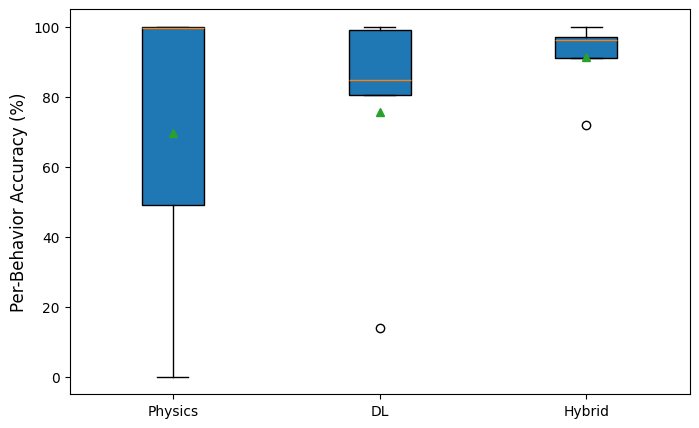

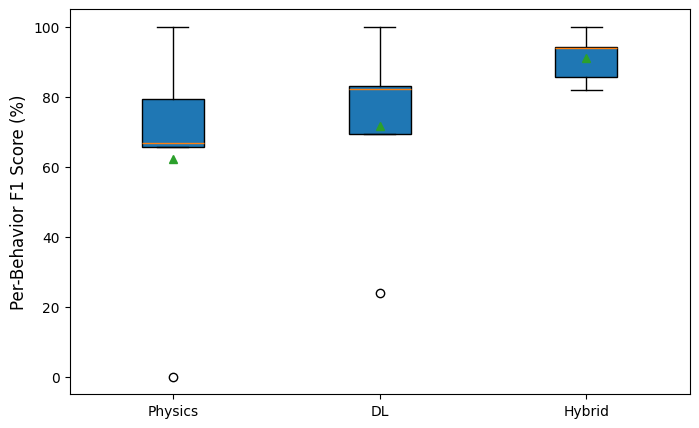

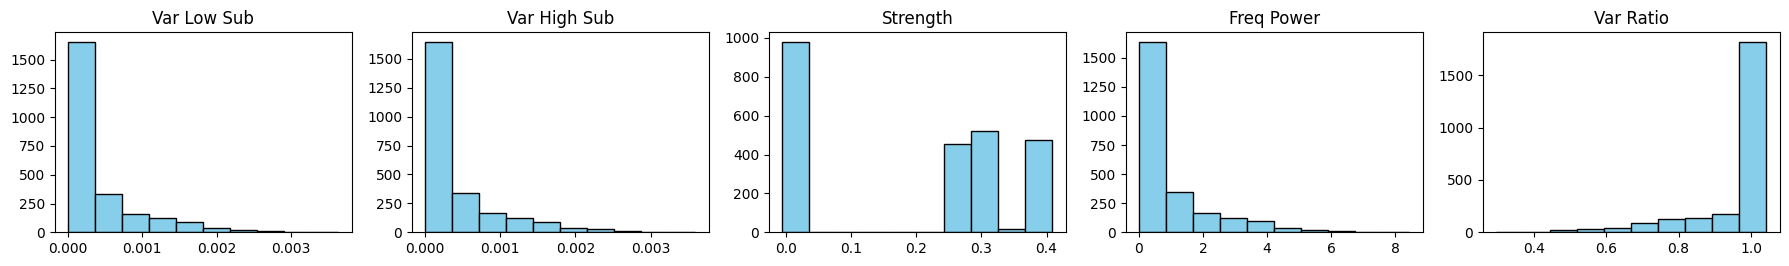

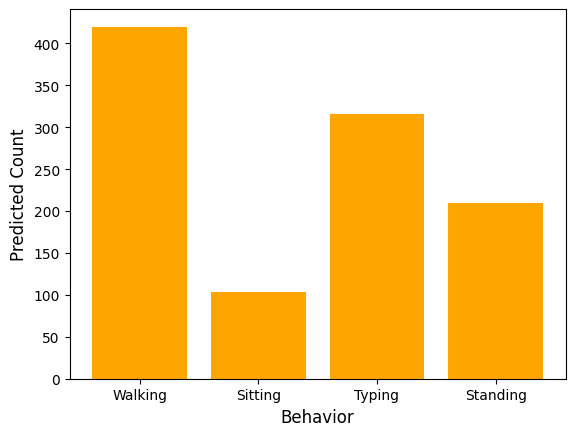

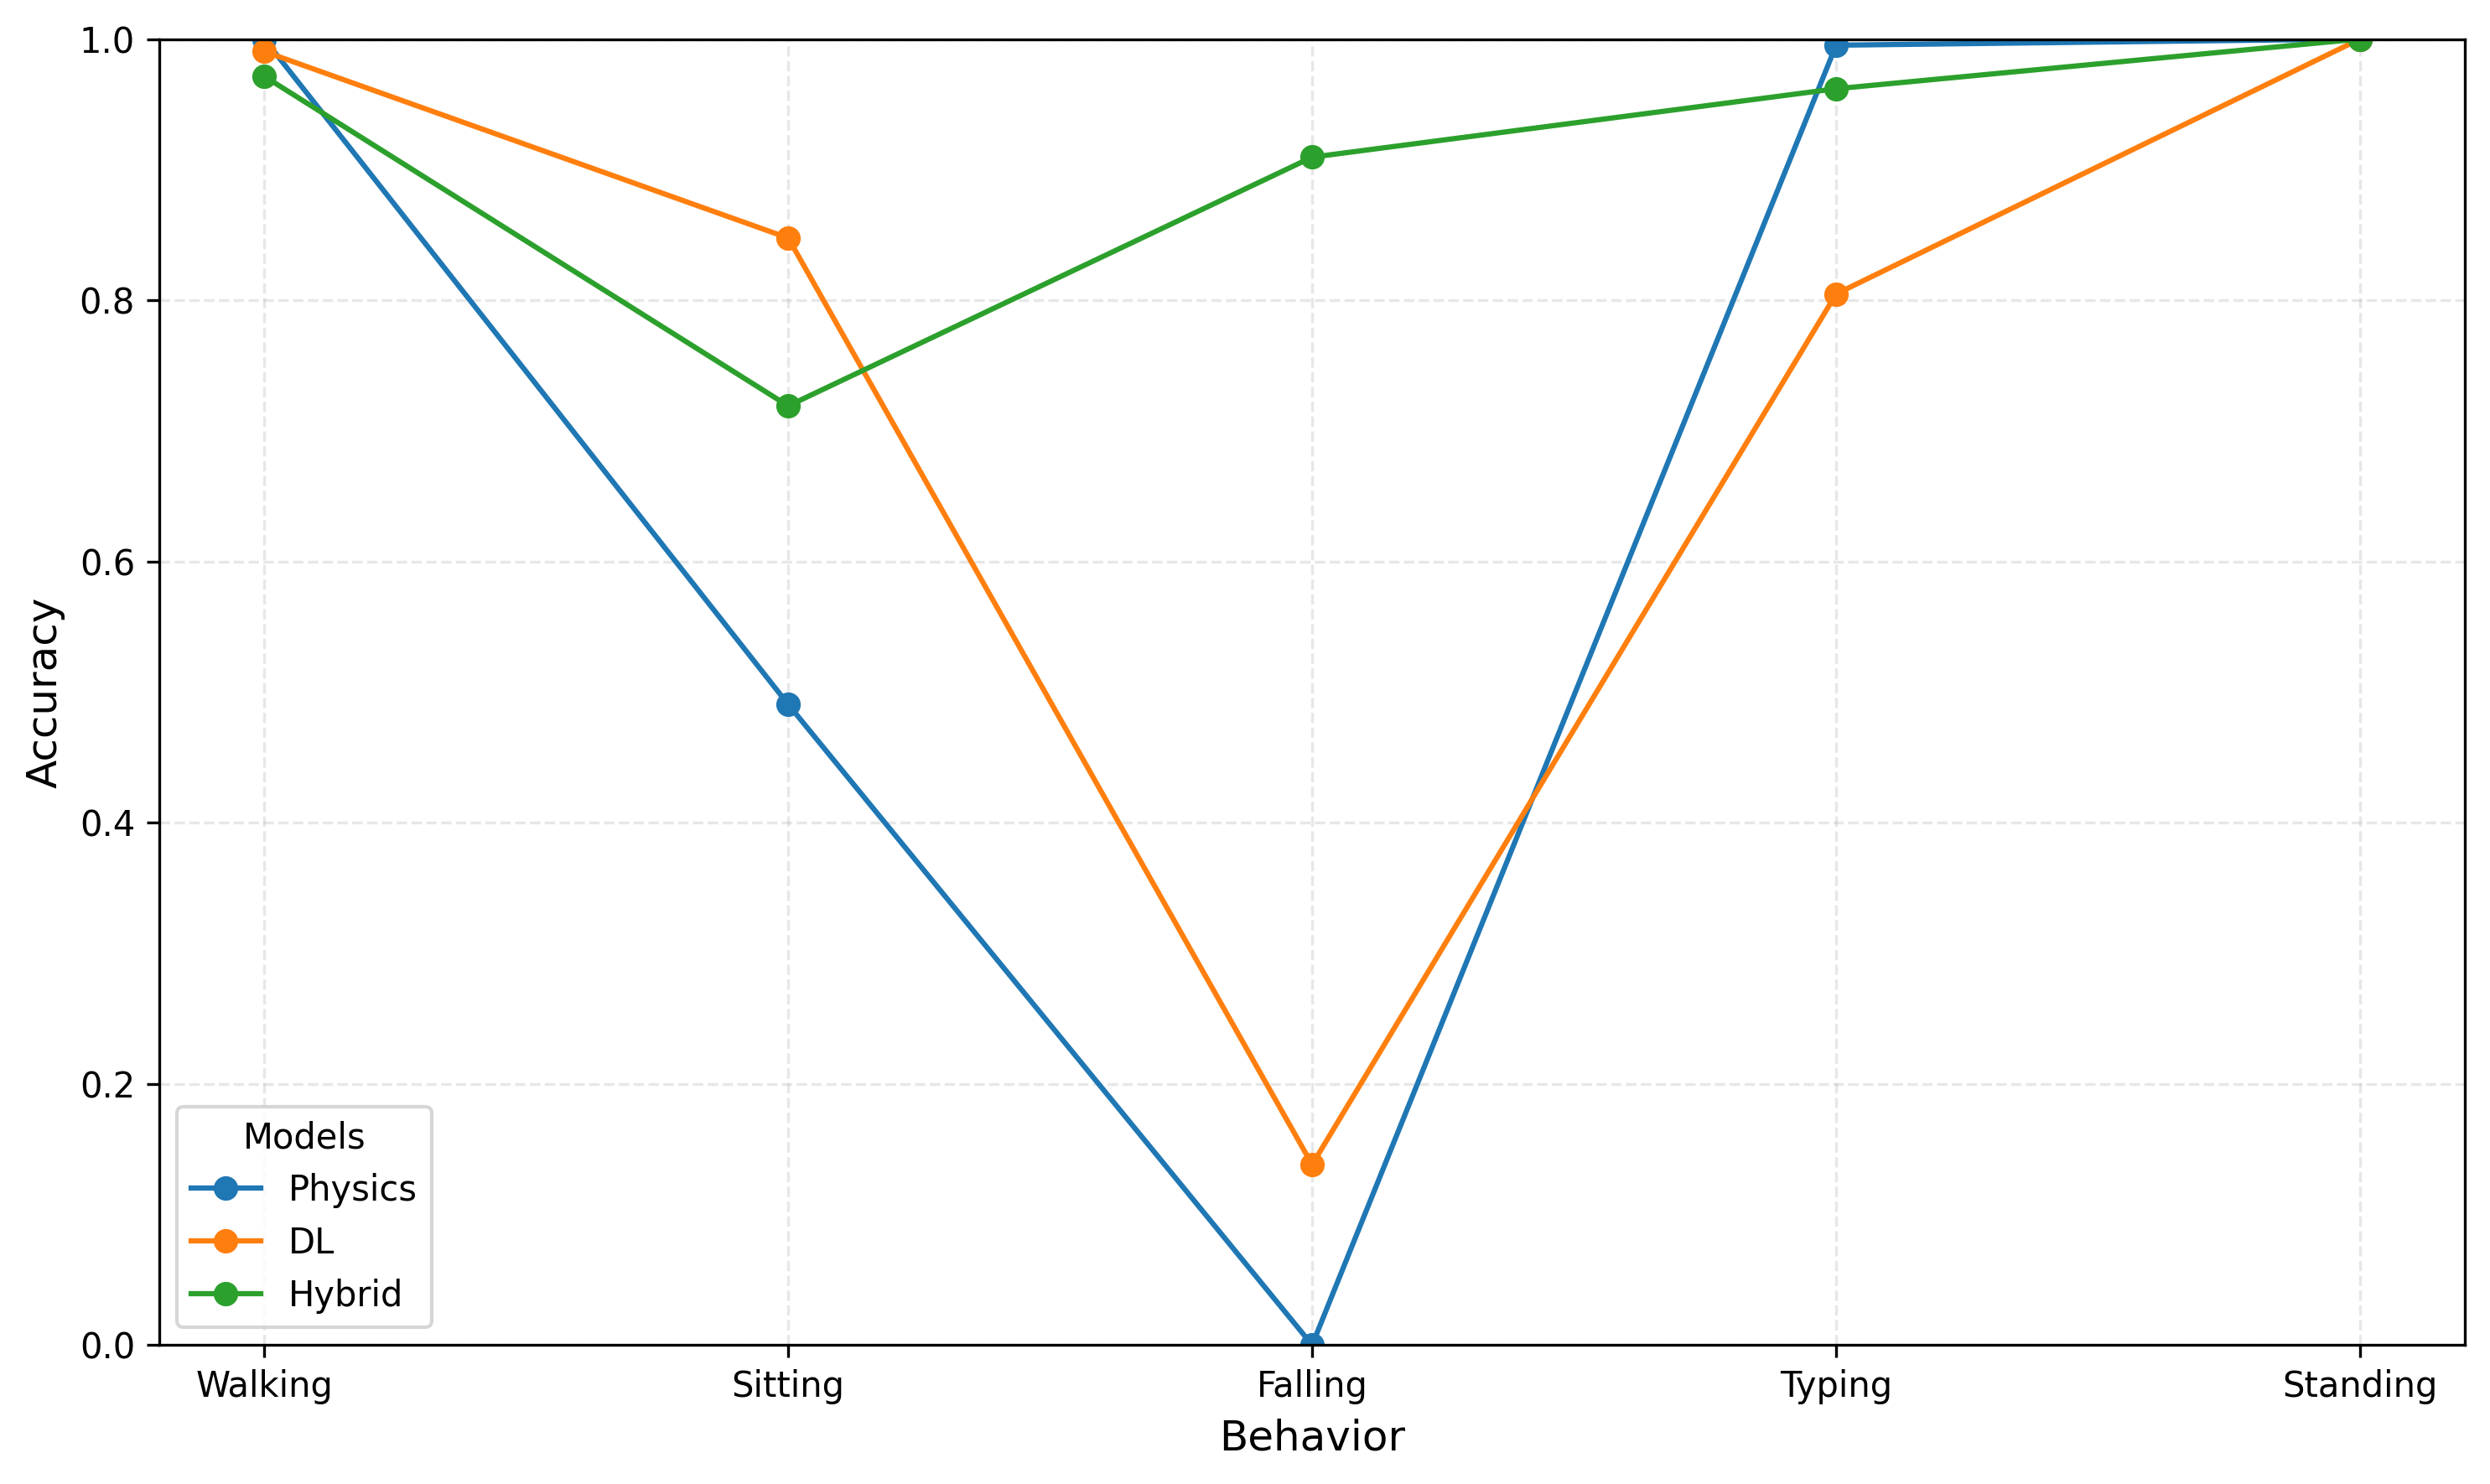

In [28]:
# 1. 箱线图：行为级准确率和F1
methods = ['Physics', 'DL', 'Hybrid']
acc_data = [per_acc_phy, per_acc_dl, per_acc_hybrid]
f1_data = [per_f1_phy, per_f1_dl, per_f1_hybrid]

plt.figure(figsize=(8, 5))
plt.boxplot(acc_data, labels=methods, patch_artist=True, showmeans=True)
plt.ylabel('Per-Behavior Accuracy (%)', fontsize=12)
#plt.title('Per-Behavior Accuracy by Method')
plt.savefig('behavior_accuracy_boxplot.png')

plt.figure(figsize=(8, 5))
plt.boxplot(f1_data, labels=methods, patch_artist=True, showmeans=True)
plt.ylabel('Per-Behavior F1 Score (%)', fontsize=12)
#plt.title('Per-Behavior F1 Score by Method')
plt.savefig('behavior_f1_boxplot.png')

# 2. Physics特征分布
phy_names = ["Var Low Sub", "Var High Sub", "Strength", "Freq Power", "Var Ratio"]
plt.figure(figsize=(18, 3))
for i, name in enumerate(phy_names):
    plt.subplot(1, 5, i+1)
    plt.hist(phy_train[:, i], bins=10, color='skyblue', edgecolor='k')
    plt.title(name, fontsize=12)
#plt.suptitle('Physics Feature Distributions (train set)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('physics_features_histogram.png')

# 3. Physics预测类别分布（测试集）
plt.figure()
unique_labels, label_counts = np.unique(phy_test_pred, return_counts=True)
plt.bar([behaviors[k] for k in unique_labels], label_counts, color='orange')
plt.xlabel('Behavior', fontsize=12)
plt.ylabel('Predicted Count', fontsize=12)
#plt.title('Physics Model: Predicted Label Distribution (test set)')
plt.savefig('physics_pred_class_dist.png')

# 保证per_acc_phy, per_acc_dl, per_acc_hybrid均为0-100之间%
per_behavior_acc = {
    'Physics': per_acc_phy / 100 if np.max(per_acc_phy) > 1.1 else per_acc_phy,
    'DL': per_acc_dl / 100 if np.max(per_acc_dl) > 1.1 else per_acc_dl,
    'Hybrid': per_acc_hybrid / 100 if np.max(per_acc_hybrid) > 1.1 else per_acc_hybrid
}
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
for model in ['Physics', 'DL', 'Hybrid']:
    ax.plot(behaviors, per_behavior_acc[model], marker='o', label=model)
ax.set_xlabel('Behavior', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_ylim(0, 1)
ax.legend(title='Models')
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('line_accuracy_trend.pdf', format='pdf', bbox_inches='tight')
plt.show()


plt.close('all')

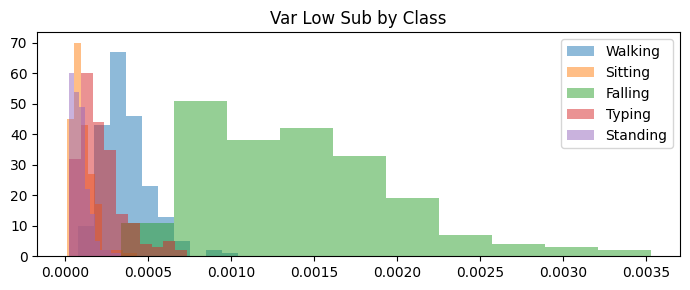

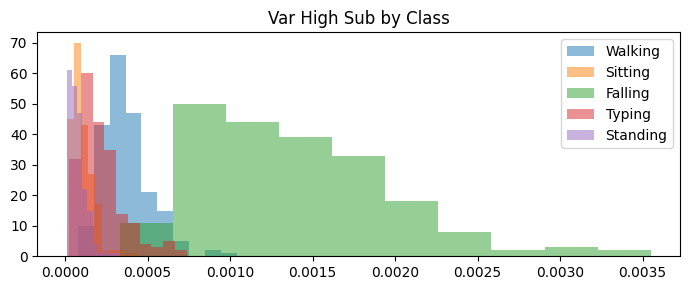

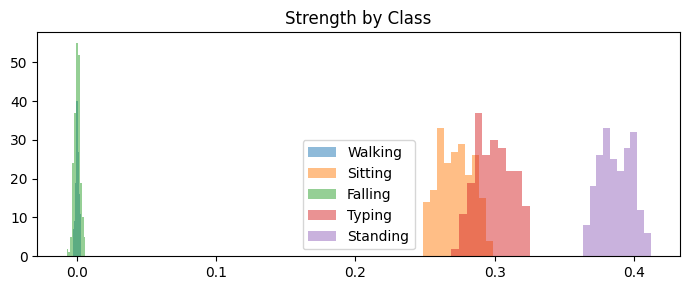

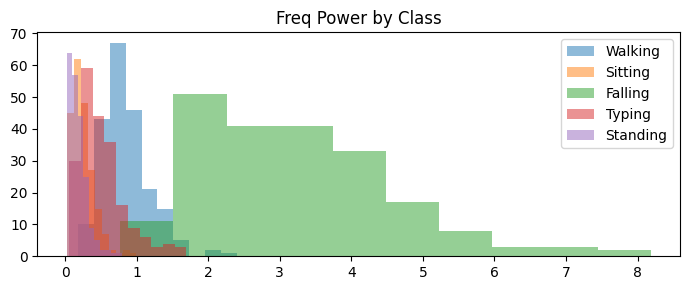

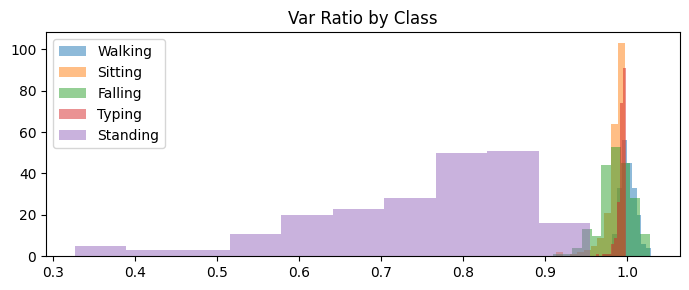

In [16]:
import matplotlib.pyplot as plt
phy_names = ["Var Low Sub", "Var High Sub", "Strength", "Freq Power", "Var Ratio"]
for i, name in enumerate(phy_names):
    plt.figure(figsize=(7,3))
    for cls in range(num_classes):
        plt.hist(phy_test[y_test == cls, i], bins=10, alpha=0.5, label=behaviors[cls])
    plt.title(f"{name} by Class")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'phy_{name}_by_class.png')
    plt.show()
    plt.close()